主要是为了测试编码器的性能，聚类二维可视化

2024-04-23 16:26:55,887 - root - INFO - Running on cuda:0
2024-04-23 16:26:55,887 - root - INFO - Running on cuda:0
2024-04-23 16:26:55,887 - root - INFO - Running on cuda:0
2024-04-23 16:26:55,934 - root - INFO - unseen domain: VOC2007
2024-04-23 16:26:55,934 - root - INFO - unseen domain: VOC2007
2024-04-23 16:26:55,934 - root - INFO - unseen domain: VOC2007
2024-04-23 16:26:55,946 - root - INFO - CLIENT_ORDER['SUN09', 'Caltech101', 'LabelMe', 'VOC2007']
2024-04-23 16:26:55,946 - root - INFO - CLIENT_ORDER['SUN09', 'Caltech101', 'LabelMe', 'VOC2007']
2024-04-23 16:26:55,946 - root - INFO - CLIENT_ORDER['SUN09', 'Caltech101', 'LabelMe', 'VOC2007']
2024-04-23 16:27:01,189 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-04-23 16:27:01,189 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-04-23 16:27:01,189 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotli

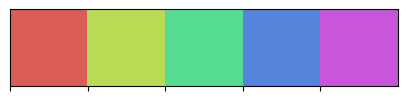

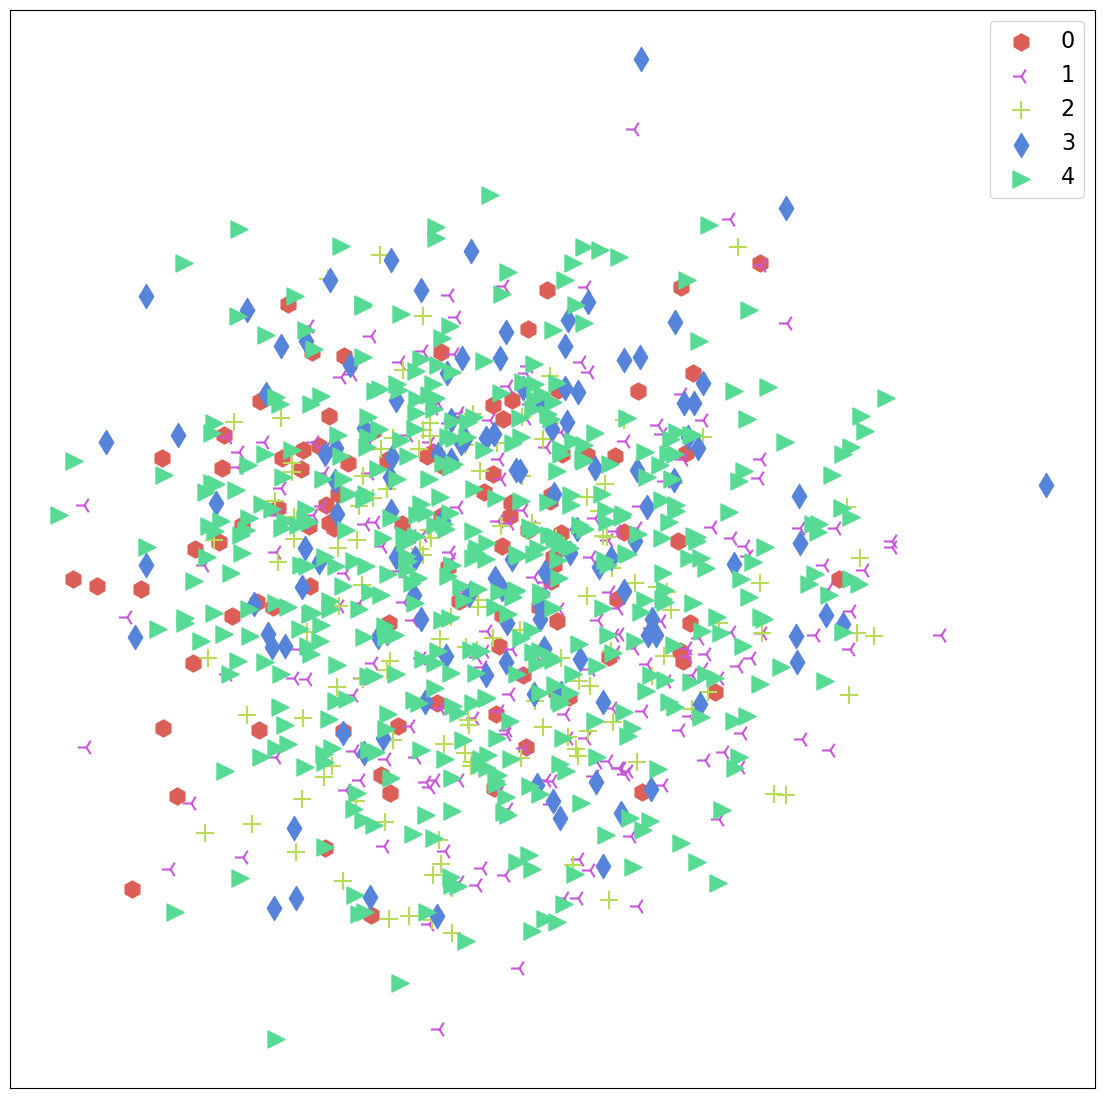

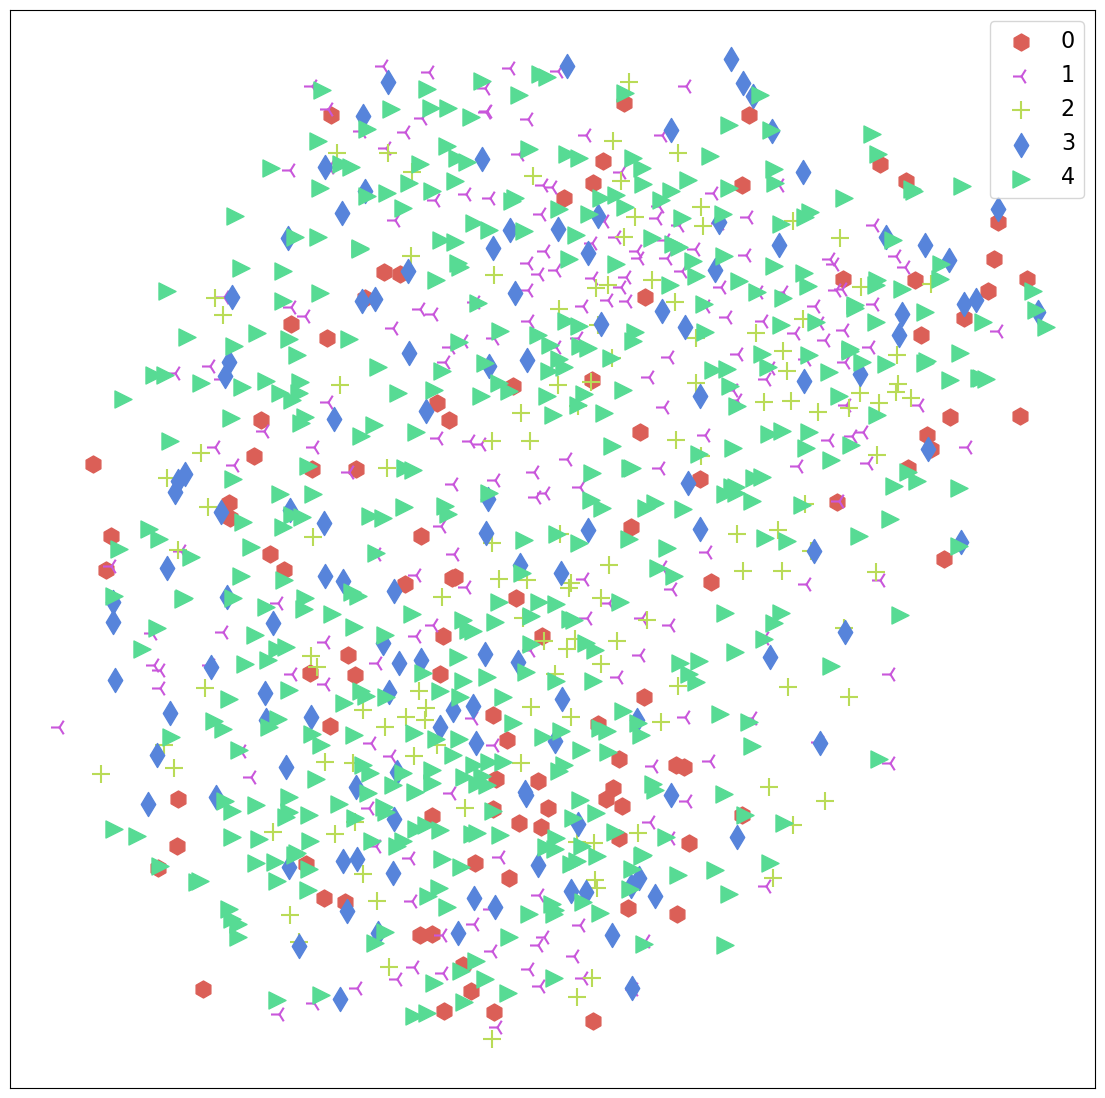

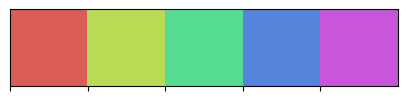

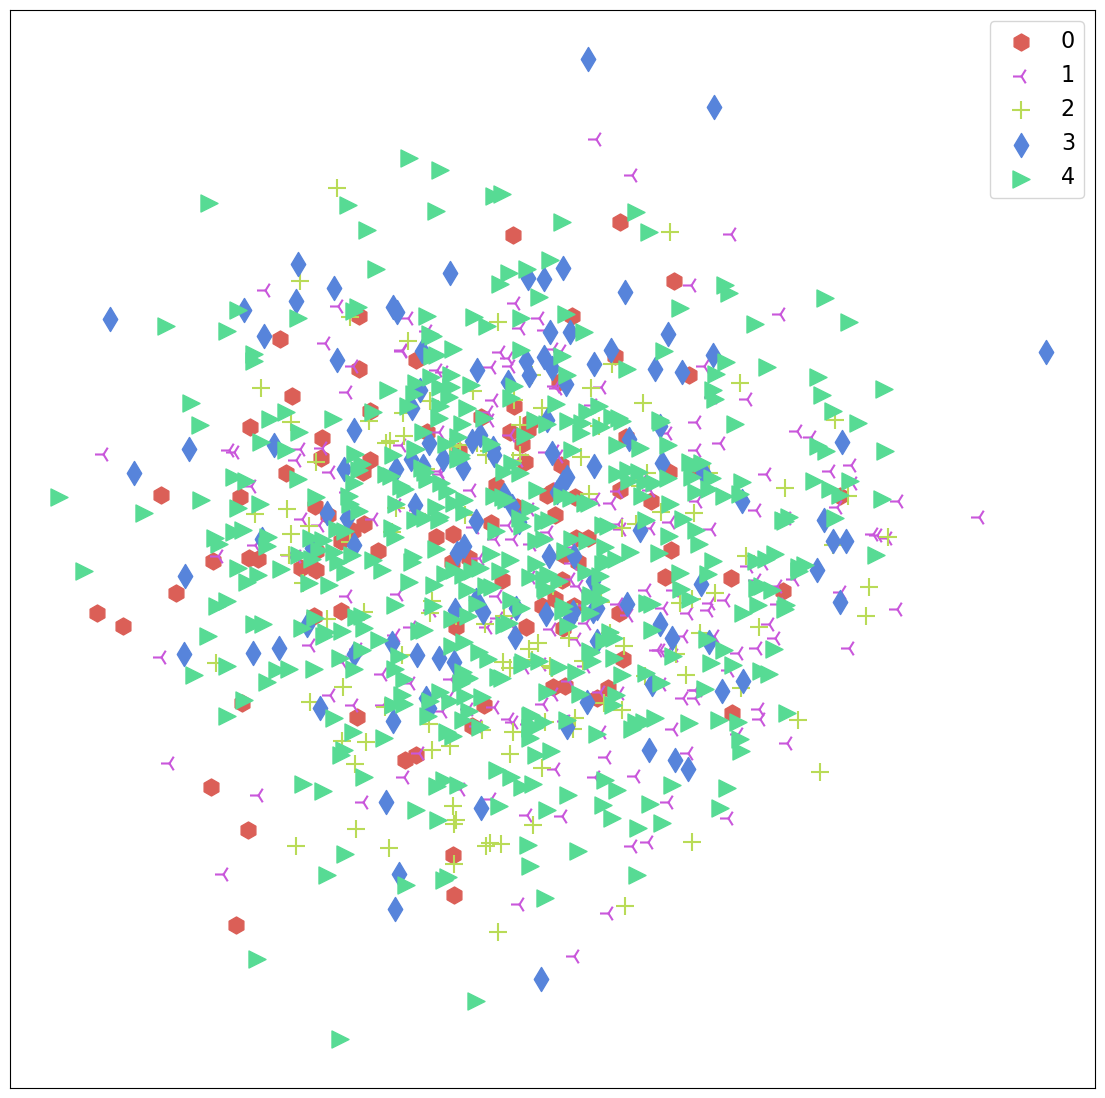

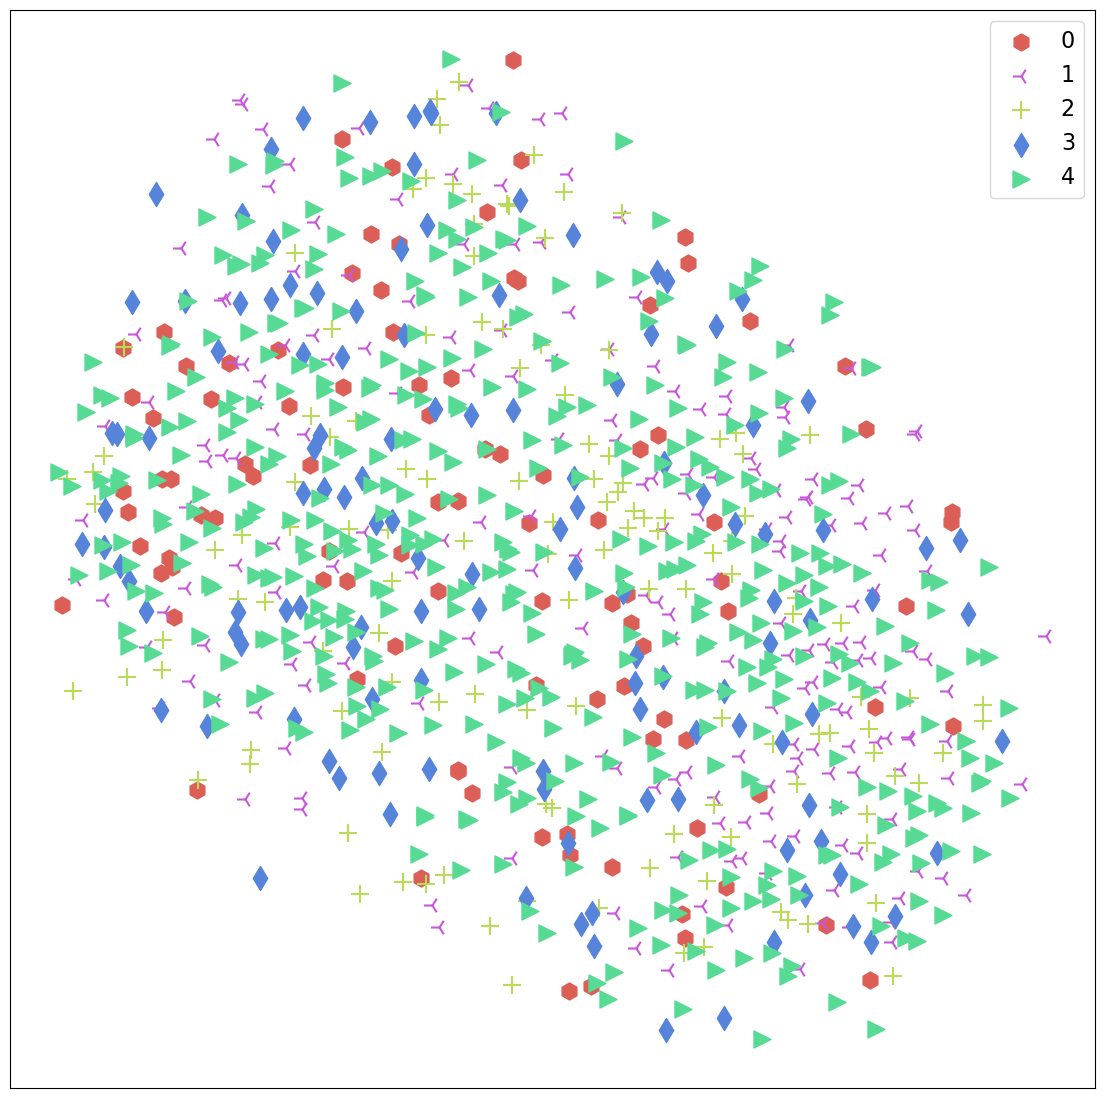

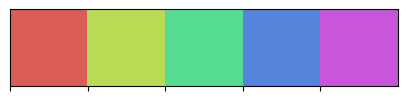

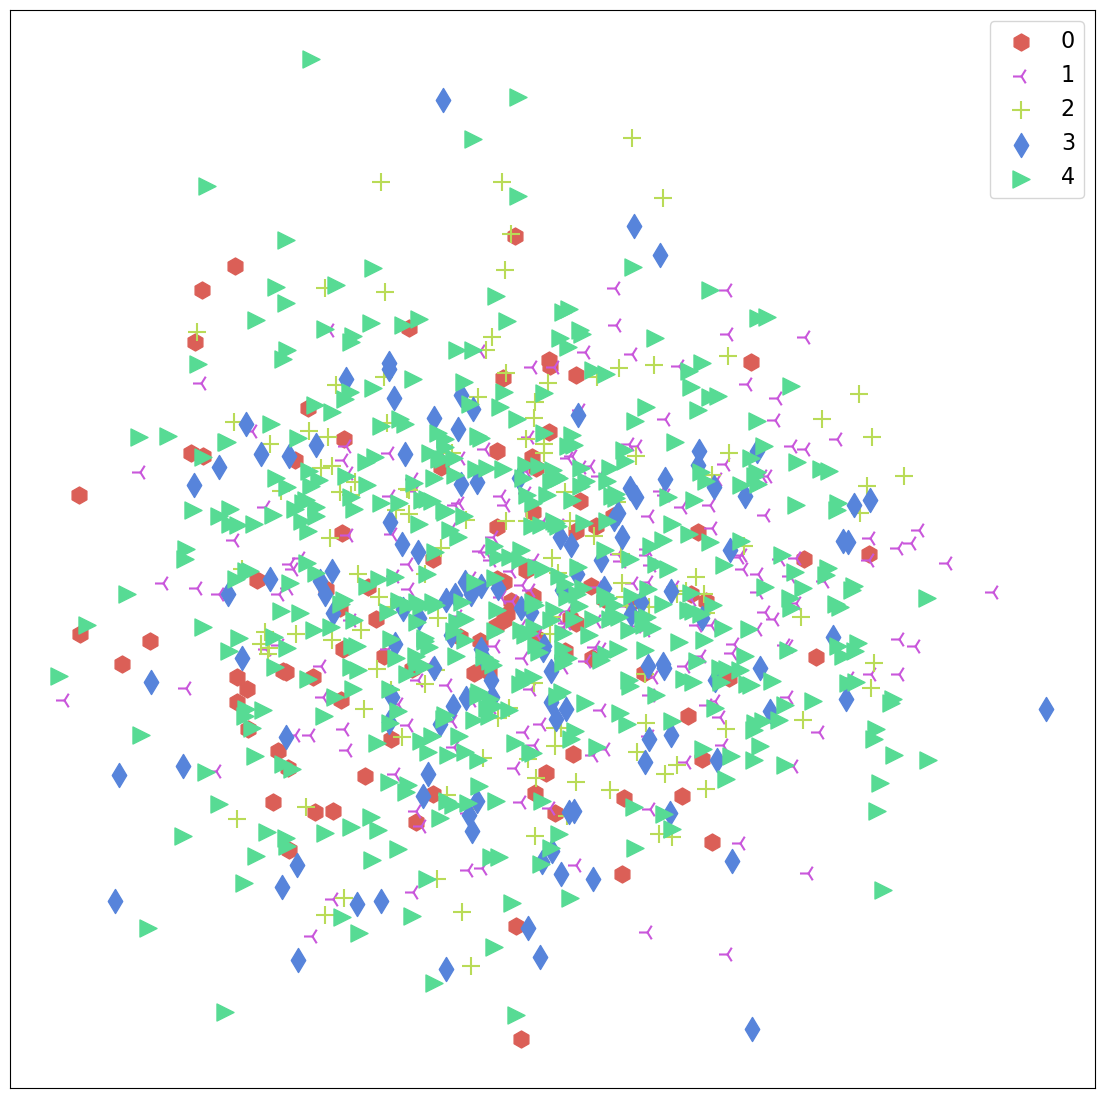

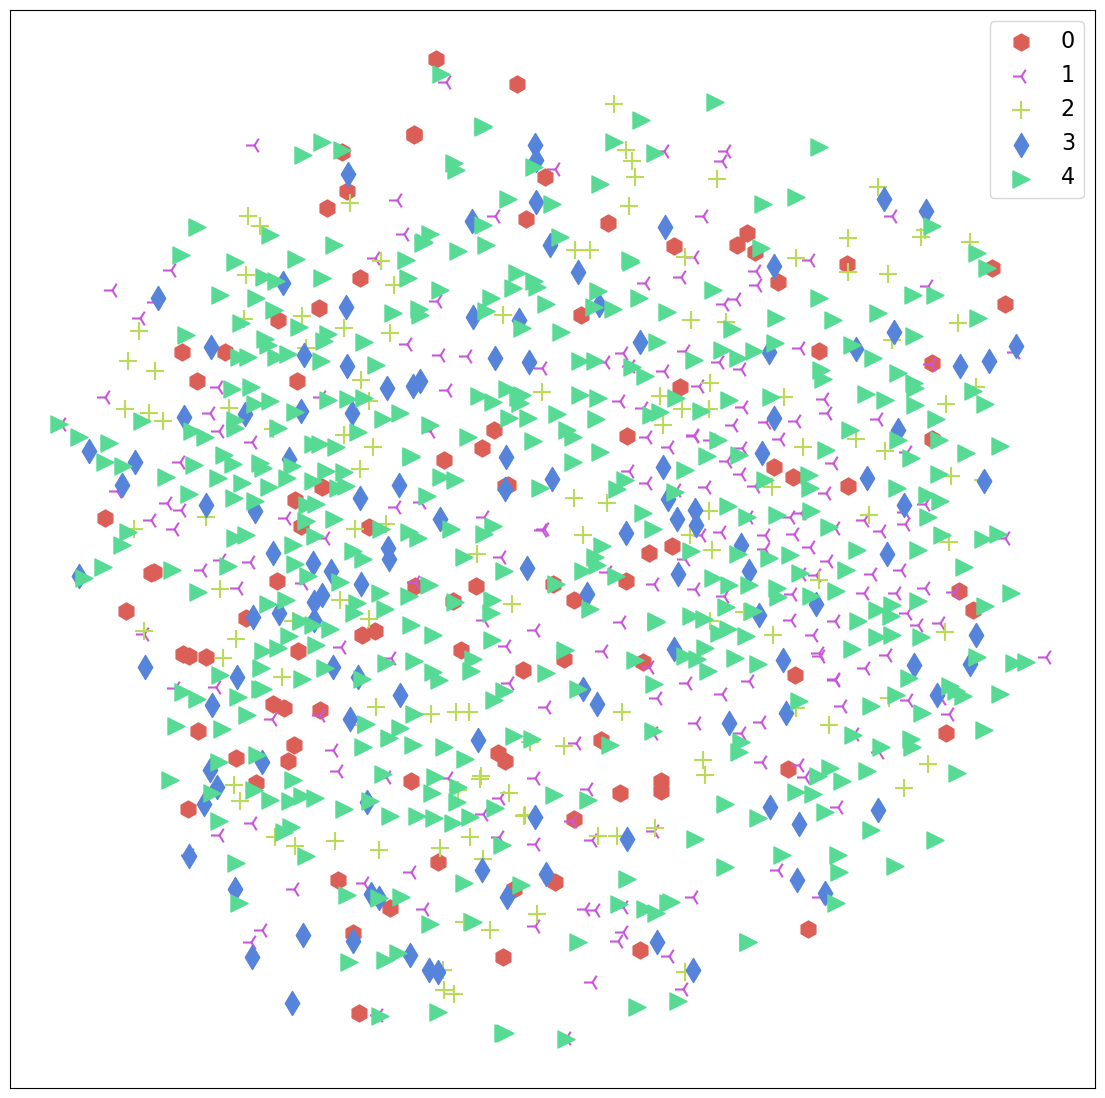

In [14]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torchvision.models.feature_extraction import create_feature_extractor
import seaborn as sns
import random
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
import logging
torch.backends.cudnn.enable =True
torch.backends.cudnn.benchmark = True

from PIL import Image,ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torch.utils import data
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


class Data(object):
    def __init__(self, dataset, iteration, logger):
        client = None

        if dataset == 'vlcs':
            if iteration == 0:
                client=['SUN09', 'Caltech101','LabelMe','VOC2007']
            if iteration == 1:
                client=['Caltech101','VOC2007','SUN09', 'LabelMe']
            if iteration == 2:
                client=['SUN09', 'LabelMe','VOC2007','Caltech101']
            if iteration == 3:
                client=['LabelMe','Caltech101','VOC2007','SUN09']
            if client is not None:
                self.train_loader, self.test_loader,self.target_loader, self.target_data = get_vlcs_loaders(client, logger)
                                                               
        logger.info('CLIENT_ORDER{}'.format(client))



class Loader_dataset(data.Dataset):
    def __init__(self, path, tranforms = None):
        self.path = path
        self.dataset = datasets.ImageFolder(path, transform=tranforms)
        self.length = self.dataset.__len__()
        self.transform = tranforms

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        data, label = self.dataset.__getitem__(idx)
        return data, label

def get_vlcs_loaders(client, logger):
    path_root = '/home/mwj/mycode2/G2G/G2G/datasets/VLCS/VLCS/'
    trans0 = transforms.Compose([transforms.RandomResizedCrop(225, scale=(0.7, 1.0)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomGrayscale(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    trans1 = transforms.Compose([transforms.Resize([225, 225]),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    train_path, valid_path = {}, {}
    train_datas, train_loaders = {}, {}
    valid_datas, valid_loaders = {}, {}
    for i in range(3):
        train_path[i] = path_root + client[i] + '/train'
        train_datas[i] = Loader_dataset(path=train_path[i], tranforms=trans0)
        train_loaders[i] = DataLoader(train_datas[i], 64, True, num_workers=16,pin_memory=True)

        valid_path[i] = path_root + client[i] + '/val'
        valid_datas[i] = Loader_dataset(path=valid_path[i], tranforms=trans1)
        valid_loaders[i] = DataLoader(valid_datas[i], 64, True, num_workers=16,pin_memory=True)
    target_path = path_root + client[3] + '/val'
    logger.info(f"unseen domain: {client[3]}")
    target_data = Loader_dataset(target_path, trans1)
    target_loader = DataLoader(target_data, 16, True, num_workers=16,pin_memory=True)
    # logger.info(f'client list: {client}')
    return train_loaders, valid_loaders, target_loader, target_data.dataset

# 定义对比学习模型
class SimCLR(nn.Module):
    def __init__(self, in_channel, embedding_d):
        super(SimCLR, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.projection_head = nn.Sequential(
            nn.Linear(2304, 2048),
            nn.ReLU(),
            nn.Linear(2048, embedding_d)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        embeddings = self.projection_head(x)
        return x, embeddings

class Classifier(torch.nn.Module):
    def __init__(self, simclr_model, num_class=5):
        super(Classifier, self).__init__()
        # encoder
        self.encoder = simclr_model.encoder
        # classifier
        self.fc = nn.Linear(3 * 3 * 256, num_class, bias=True)

        for param in self.encoder.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.encoder(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.fc(feature)
        return feature, out



def logger_config(log_path,logging_name):
    logger = logging.getLogger(logging_name)
    logger.setLevel(level=logging.DEBUG)
    file_handler = logging.FileHandler(log_path, encoding='UTF-8')
    file_handler.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    # 创建一个处理器，用于将日志输出到控制台
    console_handler = logging.StreamHandler()
    console_handler.setLevel(logging.DEBUG)  # 设置控制台日志级别
    console_handler.setFormatter(formatter)
    # 将处理器添加到 logger
    logger.addHandler(console_handler)

    return logger



logger = logger_config(log_path='train.txt', logging_name='')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
logger.info(f'Running on {device}')

Data = Data('vlcs', 0, logger)

test_dataset = Data.target_data

for num in range(1, 4):
    cl_model = SimCLR(3, 128).to(device)
    cl_model.load_state_dict(torch.load(f"./save/model/{num}_simclr.pth"))
    # 这里的10应该为5
    clser = Classifier(cl_model, 10).to(device)
    clser.load_state_dict(torch.load(f"./save/model/{num}_clser.pth"))

    model_trunc = create_feature_extractor(clser, return_nodes={'encoder': 'semantic_feature'})
    
    data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
    encoding_array = []
    labels_list = []
    for batch_idx, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels.item())
        feature = model_trunc(images)['semantic_feature'].squeeze().flatten().detach().cpu().numpy() # 执行前向预测，得到 avgpool 层输出的语义特征
        encoding_array.append(feature)
    encoding_array = np.array(encoding_array)
    # 保存为本地的 npy 文件
    np.save(os.path.join("/home/mwj/mycode2/G2G/G2G/logger/2024_04_23_12_11_56_vlcs-r50-lr0.0008-le7-bs64-alpha0.5-beta0.5-it0-fed_adv/save/", f'{num}_50_clser测试集语义特征_mnist.npy'), encoding_array)


    marker_list = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', '*', 'h', 'H', '+', 'x', 'X', 'D', 'd', '|', '_', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    class_list = test_dataset.classes
    n_class = len(class_list) # 测试集标签类别数
    palette = sns.hls_palette(n_class) # 配色方案
    sns.palplot(palette)
    # 随机打乱颜色列表和点型列表
    random.seed(1234)
    random.shuffle(marker_list)
    random.shuffle(palette)


    for method in ['PCA', 'TSNE']:
        #选择降维方法
        if method == 'PCA': 
            X_2d = PCA(n_components=2).fit_transform(encoding_array)
        if method == 'TSNE': 
            X_2d = TSNE(n_components=2, random_state=0, n_iter=20000).fit_transform(encoding_array)

        class_to_idx = test_dataset.class_to_idx

        plt.figure(figsize=(14, 14))
        for idx, fruit in enumerate(class_list): # 遍历每个类别
            #print(fruit)
            # 获取颜色和点型
            color = palette[idx]
            marker = marker_list[idx%len(marker_list)]
            # 找到所有标注类别为当前类别的图像索引号
            indices = np.where(np.array(labels_list)==class_to_idx[fruit])
            plt.scatter(X_2d[indices, 0], X_2d[indices, 1], color=color, marker=marker, label=fruit, s=150)
        plt.legend(fontsize=16, markerscale=1, bbox_to_anchor=(1, 1))
        plt.xticks([])
        plt.yticks([])

        dim_reduc_save_path = os.path.join('/home/mwj/mycode2/G2G/G2G/logger/2024_04_23_12_11_56_vlcs-r50-lr0.0008-le7-bs64-alpha0.5-beta0.5-it0-fed_adv/save/', f'{num}_50_clser_mnist_语义特征{method}二维降维可视化.pdf')

        plt.savefig(dim_reduc_save_path, dpi=300, bbox_inches='tight') # 保存图像